In [1]:
!rm -rf /kaggle/working/*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import random
import cv2
import tensorflow as tf
import time
import random
from pathlib import Path

from tensorflow.keras import datasets, layers, models,applications,losses,optimizers,metrics,Model,backend

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import resnet,Xception

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


tf.__version__, np.__version__
target_shape = (200, 200)

In [3]:
!rm -rf /kaggle/working/*

In [4]:
!pip install gdown

In [5]:
!gdown 1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By

Downloading...
From: https://drive.google.com/uc?id=1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By
To: /kaggle/working/CV_2023_SC_Dataset.zip
100%|███████████████████████████████████████| 1.20M/1.20M [00:00<00:00, 117MB/s]


In [6]:
!pwd

/kaggle/working


In [7]:
!unzip /kaggle/working/CV_2023_SC_Dataset.zip -d /kaggle/working/data

Archive:  /kaggle/working/CV_2023_SC_Dataset.zip
   creating: /kaggle/working/data/personA/Test/
  inflating: /kaggle/working/data/personA/Test/personA_10.png  
  inflating: /kaggle/working/data/personA/Test/personA_13.png  
  inflating: /kaggle/working/data/personA/Test/personA_2.png  
  inflating: /kaggle/working/data/personA/Test/personA_20.png  
  inflating: /kaggle/working/data/personA/Test/personA_27.png  
  inflating: /kaggle/working/data/personA/Test/personA_29.png  
  inflating: /kaggle/working/data/personA/Test/personA_30.png  
  inflating: /kaggle/working/data/personA/Test/personA_42.png  
  inflating: /kaggle/working/data/personA/Test/personA_SigVerificationTestLabels.csv  
   creating: /kaggle/working/data/personA/Train/
  inflating: /kaggle/working/data/personA/Train/personA_1.png  
  inflating: /kaggle/working/data/personA/Train/personA_11.png  
  inflating: /kaggle/working/data/personA/Train/personA_12.png  
  inflating: /kaggle/working/data/personA/Train/personA_14.png

Making every train and test together 

In [8]:
import os
persons = ['A','B','C','D','E']
os.mkdir('/kaggle/working/Train')
os.mkdir('/kaggle/working/Test')
for p in persons:
    os.mkdir('/kaggle/working/Train/person'+p)
    os.mkdir('/kaggle/working/Test/person'+p)
    

In [9]:
import shutil
import os
import glob
for p in os.listdir('data'):
  print(p)
  for f in os.listdir(f'data/{p}'):
    for d in glob.glob(f'/kaggle/working/data/{p}/{f}/*'):
      shutil.move(d,f'/kaggle/working/{f}/{p}')

personC
personE
personA
personB
personD


Putting DataFrames together

In [10]:
persons = ['A','B','C','D','E']
df = pd.DataFrame()
for person in  persons:
  path = f'/kaggle/working/Train/person{person}/person{person}_SigVerificationTrainLabels.csv'
  tempdf = pd.read_csv(path)
  tempdf['person'] = person
  df = df.append(tempdf)

In [11]:
os.listdir('Test/personA')

['personA_42.png',
 'personA_2.png',
 'personA_10.png',
 'personA_30.png',
 'personA_13.png',
 'personA_20.png',
 'personA_29.png',
 'personA_27.png',
 'personA_SigVerificationTestLabels.csv']

In [12]:
alldf=pd.DataFrame()
for person in  persons:
  path = f'/kaggle/working/Train/person{person}/person{person}_SigVerificationTrainLabels.csv'
  path2 = f'/kaggle/working/Test/person{person}/person{person}_SigVerificationTestLabels.csv'
  tempdf = pd.read_csv(path)
  tempdf2 = pd.read_csv(path2)
  tempdf['person'] = person
  tempdf2['person'] = person
  alldf = alldf.append(tempdf)  
  alldf = alldf.append(tempdf2)

In [13]:
df.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [14]:
forged = []
real = []
tripletList = []
forged = df[df["label"]=="forged"]
real = df[df.label=="real"]

In [15]:
forged.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [16]:
def create_triplets(real,fake, max_files=10):
    triplets = []
    a = 0
    for person in real["person"].unique(): # a b c d e
        dfreal = real[real["person"]==person]
        dfake = fake[fake["person"]==person]
        for indi,rowi in dfreal.iterrows():
            for indj,rowj in dfreal.iterrows():
                if rowj["image_name"]==rowi["image_name"]:continue
                anchor = rowi["image_name"]
                positive= rowj["image_name"]
                negative = dfake.sample(n=1).iloc[0]["image_name"]
                triplets.append((anchor,positive,negative))
        
        
        #       for i in range(len(real[real["person"]==person])):
#         for j in range(i+1,len(real[real["person"]==person])):
#             anchor = real.iloc[(i+a)%(len(real)-1)]["image_name"]
#             positive = real.iloc[(j+a)%(len(real)-1)]["image_name"]
#             negative = fake.iloc[(j+a)%(len(real)-1)]["image_name"]    
#             triplets.append((anchor,positive,negative))
#       a = a+40
            
    random.shuffle(triplets)
    return triplets

In [17]:
trip = create_triplets(real,forged)

In [18]:
trip[0:5]

[('personB_6.png', 'personB_17.png', 'personB_37.png'),
 ('personD_38.png', 'personD_48.png', 'personD_4.png'),
 ('personA_44.png', 'personA_23.png', 'personA_1.png'),
 ('personA_15.png', 'personA_41.png', 'personA_31.png'),
 ('personA_17.png', 'personA_8.png', 'personA_21.png')]

In [19]:
os.mkdir('/kaggle/working/allImages')

In [20]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/kaggle/working/Train/{p}/*.png'):
    shutil.copy(d,f'/kaggle/working/allImages/')

personC
personE
personA
personB
personD


In [21]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/kaggle/working/Test/{p}/*.png'):
    shutil.copy(d,f'/kaggle/working/allImages')

personC
personE
personA
personB
personD


In [22]:
ROOT = '/kaggle/working/allImages'
def read_image(index):
    path = os.path.join(ROOT, index)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128)) 
    return image


In [23]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        h=0
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            a=read_image(a)
            p=read_image(p)
            n=read_image(n)
            anchor.append(preprocess_input(a))
            positive.append(preprocess_input(p))
            negative.append(preprocess_input(n))
            h+=1
            j+=1
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
#         if preprocess:
#             anchor = preprocess_input(anchor)
#             positive = preprocess_input(positive)
#             negative = preprocess_input(negative)
    yield ([anchor, positive, negative])        


In [24]:
import warnings;warnings.filterwarnings('ignore')

In [25]:
trip = create_triplets(real,forged)

In [26]:
trip[0:5]

[('personE_4.png', 'personE_2.png', 'personE_25.png'),
 ('personB_35.png', 'personB_7.png', 'personB_31.png'),
 ('personB_17.png', 'personB_23.png', 'personB_16.png'),
 ('personB_23.png', 'personB_8.png', 'personB_5.png'),
 ('personB_15.png', 'personB_39.png', 'personB_1.png')]

put all images together

In [27]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])




Setting up the embedding generator model (encoder)

# Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

# Siames i hope

In [28]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [29]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

2022-12-26 21:19:42.281826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 21:19:42.431491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 21:19:42.432406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 21:19:42.434565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 3s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                   

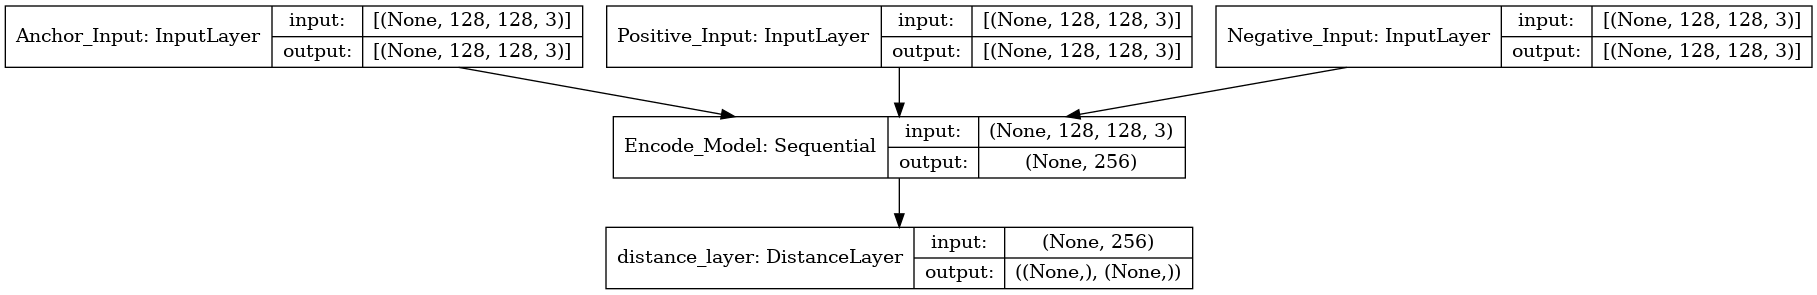

In [30]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [31]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [32]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [33]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [34]:
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
rng = RandomState()
trainreal, testreal = train_test_split(real, test_size=0.3)
trainfake, testfake = train_test_split(forged, test_size=0.3)

In [35]:
# trainreal=trainreal.sort_values(by=["person"])
# trainfake=trainfake.sort_values(by=["person"])
# testreal=testreal.sort_values(by=["person"]) 
# testfake=testfake.sort_values(by=["person"]) 

In [36]:
trainfake.iloc[1]

image_name    personD_4.png
label                forged
person                    D
Name: 6, dtype: object

In [37]:
trainreal.iloc[1]

image_name    personB_8.png
label                  real
person                    B
Name: 26, dtype: object

In [38]:
train_triplet = create_triplets(trainreal,trainfake)
test_triplet = create_triplets(testreal,testfake)

In [39]:
testreal.head()

,image_name,label,person
26,personD_39.png,real,D
39,personB_19.png,real,B
31,personE_2.png,real,E
33,personB_26.png,real,B
29,personC_7.png,real,C


In [40]:
train_triplet[0:5]

[('personE_37.png', 'personE_47.png', 'personE_44.png'),
 ('personD_12.png', 'personD_42.png', 'personD_35.png'),
 ('personE_21.png', 'personE_16.png', 'personE_6.png'),
 ('personD_18.png', 'personD_13.png', 'personD_9.png'),
 ('personC_37.png', 'personC_5.png', 'personC_9.png')]

In [41]:
save_all = False
epochs = 30
batch_size = 258

max_acc = 0
train_loss = []
test_metrics = []
# siamese_model.fit_generator(get_batch(train_triplet, batch_size=batch_size)
#                             epochs=50,validation_data=get_batch(test_triplet, batch_size=batch_size))
for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model.h5")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final.h5")

2022-12-26 21:20:07.094871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-26 21:20:08.909716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



EPOCH: 1 	 (Epoch done in 21 sec)
Loss on train    = 0.8882288932800293
Accuracy on test = 0.66471

EPOCH: 2 	 (Epoch done in 9 sec)
Loss on train    = 0.7292031645774841
Accuracy on test = 0.69412

EPOCH: 3 	 (Epoch done in 8 sec)
Loss on train    = 0.5108768343925476
Accuracy on test = 0.76471

EPOCH: 4 	 (Epoch done in 8 sec)
Loss on train    = 0.35748863220214844
Accuracy on test = 0.77647

EPOCH: 5 	 (Epoch done in 8 sec)
Loss on train    = 0.210363507270813
Accuracy on test = 0.81765

EPOCH: 6 	 (Epoch done in 8 sec)
Loss on train    = 0.1237725019454956
Accuracy on test = 0.81765

EPOCH: 7 	 (Epoch done in 8 sec)
Loss on train    = 0.07468436658382416
Accuracy on test = 0.85294

EPOCH: 8 	 (Epoch done in 8 sec)
Loss on train    = 0.025117555633187294
Accuracy on test = 0.85294

EPOCH: 9 	 (Epoch done in 8 sec)
Loss on train    = 0.01970265805721283
Accuracy on test = 0.86471

EPOCH: 10 	 (Epoch done in 9 sec)
Loss on train    = 0.010196316055953503
Accuracy on test = 0.88824

E

In [42]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
__________________________________

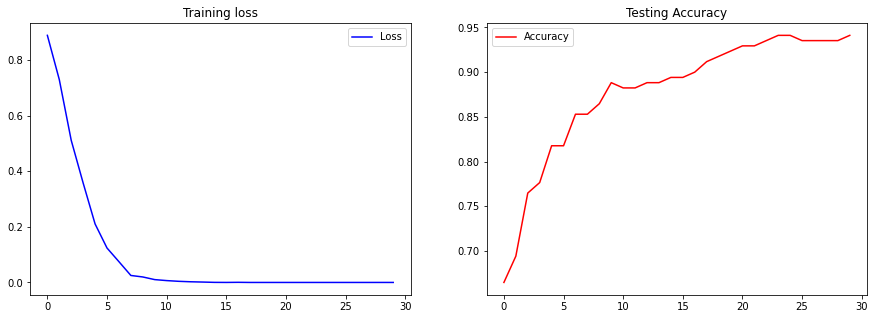

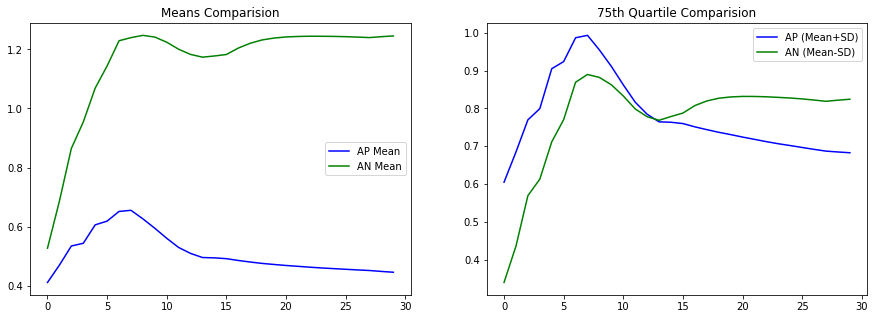

In [43]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [44]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

Accuracy of model: 1.0



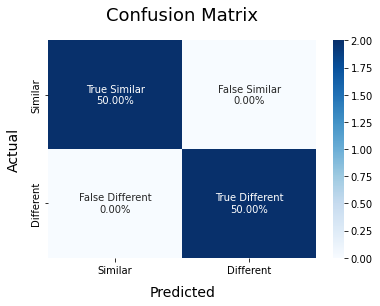

In [45]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=8):
    a, p, n = data
    print(type(a))
    print(type(p))
    print(type(n))
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [46]:
pos_list=[]
neg_list=[]
for data in get_batch(test_triplet, batch_size=500):
    a, p, n = data
    print(a.shape)
    pos_list = np.append(pos_list, classify_images(a, p))

    neg_list = np.append(neg_list, classify_images(a, n))

(170, 128, 128, 3)


In [47]:
lst=[]
image = read_image('personB_28.png')
image = preprocess_input(image)
lst.append(image)
lst=np.array(lst)
for data in get_batch(test_triplet, batch_size=500):
    a, p, n = data
    a=lst
    pos_list = np.append(pos_list, classify_images(a, p))

    neg_list = np.append(neg_list, classify_images(a, n))
    


In [48]:
def findSimilar(img1,img2,thres=1.1):
    a=read_image(img1)
    a=preprocess_input(a)
    lst1=[a]
    lst1=np.array(lst1)
    b=read_image(img2)
    b=preprocess_input(b)
    lst2=[b]
    lst2=np.array(lst2)
    xx=[]
    x=classify_images(lst1,lst2,thres)
    if x ==0: xx.append('real')
    else:xx.append('forged')
    return xx

In [49]:
testreal

,image_name,label,person
26,personD_39.png,real,D
39,personB_19.png,real,B
31,personE_2.png,real,E
33,personB_26.png,real,B
29,personC_7.png,real,C
31,personC_25.png,real,C
21,personB_15.png,real,B
37,personA_39.png,real,A
38,personC_48.png,real,C
27,personB_23.png,real,B


In [50]:
findSimilar('personB_44.png','personB_25.png')


['real']

In [51]:
encoder.save('siames.h5')

In [52]:
import os
os.chdir(r'/kaggle/working')


from IPython.display import FileLink

x=FileLink(r'siames.h5')

In [53]:
x

/kaggle/working/siames.h5